# Notebook Outline

The purpose of this notebook is to show the process of radiometric correction and some image preprocessing methods. We will be scaling Digital Numbers (DN) to TOA Radiance and TOA Reflectance. This process allows us to convert the raw sensor data into usable physical units which is often the first step in preparing analysis ready data.

As part of the notebook preparation process in the next step you will download the same image in DN, TOA Radiance, and TOA Reflectance. These have been prepared in Google Earth Engine and will be downloaded to the local Google Colab storage.

We will be comparing the outputs against the data generated by Google Earth Engine to see how our manual process compares to Google Earth Engine's output.

# Notebook Environment Setup
First we will set up the notebook environment to be able to run this demo code. 
Click the cell you want to run and press `CTRL+Enter` on your keyboard to run the cell.

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [3]:
# For raster reading/writing
import rasterio  

# Parsing XML metadata
import xml.etree.ElementTree as ET

# For plotting
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
import pandas as pd

# For image array processing
import numpy as np
from skimage.exposure import rescale_intensity, equalize_adapthist
from sklearn.metrics import r2_score

# Misc imports for type hinting and notebook handling
from typing import Tuple
import sys

Get the lesson data here. If you want to get it via Google Earth Engine then click [this link](https://code.earthengine.google.com/80de6a042757d62646f96026b20e6ce1) and it will automatically generate the GEE Task to download it to your Google Drive folder. Otherwise, you may run this cell and it can download the data from Github and it will download it to the local Google Colab instance.

In [ ]:
# Get the lesson data
!git clone https://github.com/pangeospatial/lesson-data.git

Cloning into 'lesson-data'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 2), reused 13 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [20]:
# Set paths
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    dn_tiff_path = "/content/lesson-data/radiometric-correction/L9_Digital_Numbers.tif"
    rad_tiff_path = "/content/lesson-data/radiometric-correction/L9_Radiance.tif"
    refl_tiff_path = "/content/lesson-data/radiometric-correction/L9_Reflectance.tif"
    metadata_path = "/content/lesson-data/radiometric-correction/LC09_L1TP_114051_20221106_20221106_02_T1_MTL.xml"
    img_proc_path = "/content/lesson-data/image-processing/landsat9-rgbn.tif"
else:
    dn_tiff_path = "radiometric-correction\L9_Digital_Numbers.tif"
    rad_tiff_path = "radiometric-correction\L9_Radiance.tif"
    refl_tiff_path = "radiometric-correction\L9_Reflectance.tif"
    metadata_path = "radiometric-correction\LC09_L1TP_114051_20221106_20221106_02_T1_MTL.xml"
    img_proc_path = "image-processing\landsat9-rgbn.tif"

The cells below are some helper functions that are not directly related to radiometric correction but will be useful during the demo.

In [5]:
def prep_landsat_for_preview(arr: np.ndarray, composite: str) -> np.ndarray:
  
  # Fix contrast
  low, high = np.percentile(arr, (2, 98))
  arr = rescale_intensity(arr, in_range=(low, high))
  # Scale to 8bit
  arr = (arr / arr.max()) * 255
  arr = arr.astype(np.uint8)
  
  # Load appropriate colors
  if composite == 'rgb':
    arr = np.stack([arr[3], arr[2], arr[1]])
  elif composite == 'nir':
    arr = np.stack([arr[4], arr[2], arr[1]])
  else:
    raise ValueError(f"Invalid value: '{composite}'. Valid values are 'nir' or 'rgb'")
  
  return arr

def show_r2_plots(arr_ref: pd.DataFrame, arr_test: pd.DataFrame, figsize=(18, 12)):

  # Check consistent band counts
  band_count = len(arr_ref)
  if len(arr_ref) != len(arr_test):
    raise Exception("inconsistent band count")

  # Dictionary to store dataframe objects in
  df_data = {}
  for i in range(len(arr_ref)):
    band_num = i + 1
    df_data[f"B{band_num}_REF"] = arr_ref[i].flatten()
    df_data[f"B{band_num}_TEST"] = arr_test[i].flatten()

  # Construct data frame from dictionary
  df = pd.DataFrame(df_data)

  # Get row count for figure
  rows = (band_count // 2)
  odd_num_plots = False
  if band_count % 2 > 0:
    rows += 1
    odd_num_plots = True

  fig, ax = plt.subplots(rows, 2, figsize=figsize)
  band_num = 1
  for row_i in range(rows):
    for col_i in range(2):
      if band_num <= band_count:
        ax[row_i][col_i].scatter(df[f"B{band_num}_REF"], df[f"B{band_num}_TEST"])
        r2 = r2_score(df[f'B{band_num}_REF'], df[f'B{band_num}_TEST'])      
        ax[row_i][col_i].set_title('Band {} ($R^2$={:.3f})'.format(band_num, r2))
        ax[row_i][col_i].set_xlabel('Calculated TOA')
        ax[row_i][col_i].set_ylabel('Reference TOA')
        band_num += 1
      else:
        # Delete extra plot if odd number
        if odd_num_plots:
          fig.delaxes(ax[row_i, 1])

# Basic Intro to Reading and Writing with Rasterio
When reading and writing GeoTIFF files you need the image data and the metadata. The image data can be loaded by using `read()` method and the metadata is loaded by using the `meta` property of the context manager.

```python
# This is how you read a GeoTIFF file using Rasterio.
with rasterio.open("/content/lesson-data/radiometric-correction/L9_Digital_Numbers.tif") as f:
  arr = f.read()
  meta = f.meta
```

When you write data you must ensure the metadata is also updated. For example, if you convert your image datatype from integer to float you must updated the metadata. If you modify the image size you must also updated it.

After updating your metadata, set the `rasterio.open` writing mode to write by specifying `"w"` and then add the meta file with the two asterisks as seen below:

```python
# Update the metadata using your image array properties
meta["dtype"] = arr.dtype
meta["count"] = arr.shape[0]
meta["height"] = arr.shape[1]
meta["width"] = arr.shape[2]

with rasterio.open("/content/my-new-file.tif", "w", **meta) as f:
  f.write(arr)
```

You now have a new GeoTIFF file which you can open in your standard GIS software such as QGIS or ArcMap.

# Radiometric Calibration

## Preview the Data

Let us take a look at the data we will be working with. For this data we will be looking at Landsat 9 data that is covering Legazpi City and we will only be using the first 7 bands. The image was taken just this month (November 2022).

The image composites below show the natural color image on the left, the near-infrared image in the middle, and the image histogram on the right.

Array shape: (7, 124, 191)
Image metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 191, 'height': 124, 'count': 7, 'crs': CRS.from_epsg(32651), 'transform': Affine(30.0, 0.0, 576825.0,
       0.0, -30.0, 1454835.0)}




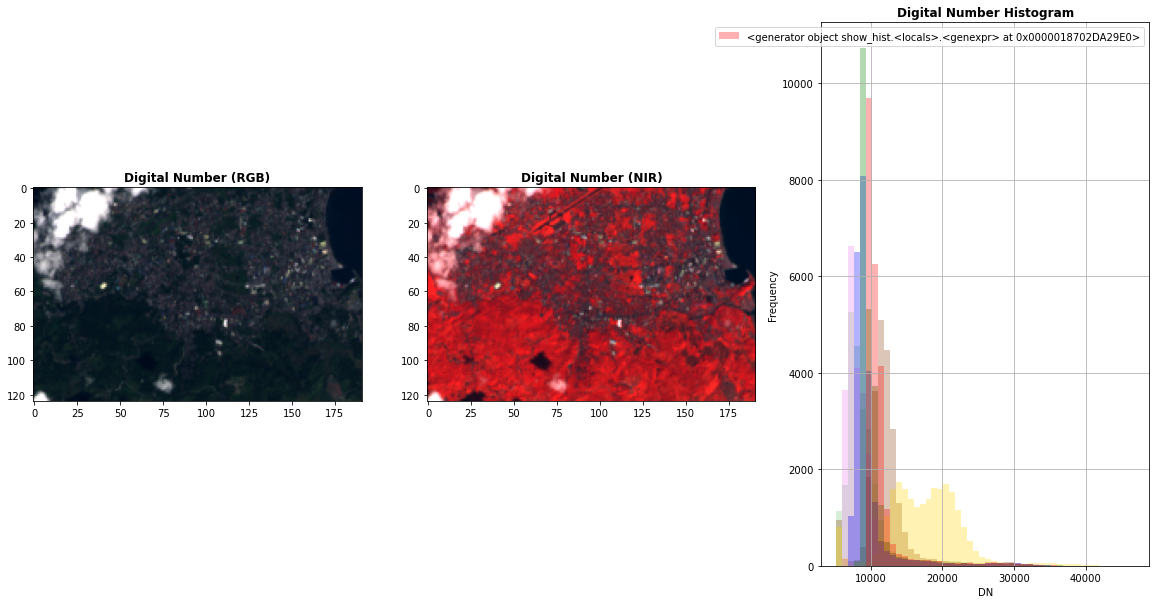

In [6]:
with rasterio.open(dn_tiff_path) as f:
  arr = f.read()
  meta = f.meta

print("Array shape:", arr.shape)
print("Image metadata:", meta)
print("\n")

# Create plots to store image arrays
fig, (ax_rgb, ax_nir, ax_hist) = plt.subplots(1, 3, figsize=(20, 10))

show(prep_landsat_for_preview(arr, 'rgb'), ax=ax_rgb, title="Digital Number (RGB)")
show(prep_landsat_for_preview(arr, 'nir'), ax=ax_nir, title="Digital Number (NIR)")
show_hist(arr, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=ax_hist, title="Digital Number Histogram")

## DN to Radiance

In [10]:
# Load metadata associated with Landsat scene
tree = ET.parse(metadata_path)
root = tree.getroot()

# Load DN raster
with rasterio.open(dn_tiff_path) as f:
  arr = f.read()

## Gain Bias Method

One of the methods we can use when performing radiometric correction is the gain/bias method. The equation is seen below:

$$
L_{\lambda}=gain*DN+bias
$$


In [11]:
# Create an empty array using the shape of the original array which will be used
# to save our results. Our output array will be using decimals (float32 type)
# so we must ensure that the array datatype is float32
arr_gainbias = np.zeros(arr.shape, np.float32)

for i, band_arr in enumerate(arr):

  # i starts at 0 index, but when referring to bands in the metadata
  # we start at 1. So we add an offset of 1.
  band_num = i + 1

  # Get gain bias
  gain = float(root.find(f".//RADIANCE_MULT_BAND_{band_num}").text)
  bias = float(root.find(f".//RADIANCE_ADD_BAND_{band_num}").text)
  print(f"BAND {band_num}")
  print("\tgain/bias values:", gain, bias)
  print()

  # Assign radiance scaled array to the new array via array indexing
  arr_gainbias[i] = gain * band_arr + bias

BAND 1
	gain/bias values: 0.012759 -63.79481

BAND 2
	gain/bias values: 0.013104 -65.52232

BAND 3
	gain/bias values: 0.012041 -60.20639

BAND 4
	gain/bias values: 0.010206 -51.02964

BAND 5
	gain/bias values: 0.0062615 -31.30744

BAND 6
	gain/bias values: 0.0015642 -7.82113

BAND 7
	gain/bias values: 0.00052817 -2.64087



So now that we have a radiometrically corrected array. Let us test it against the reference data which is `L9_Radiance.tif`. This was processed using the built-in Google Earth Engine algorithms.

We can observe a correlation of 1.0. An exact match which shows that our results are correct.

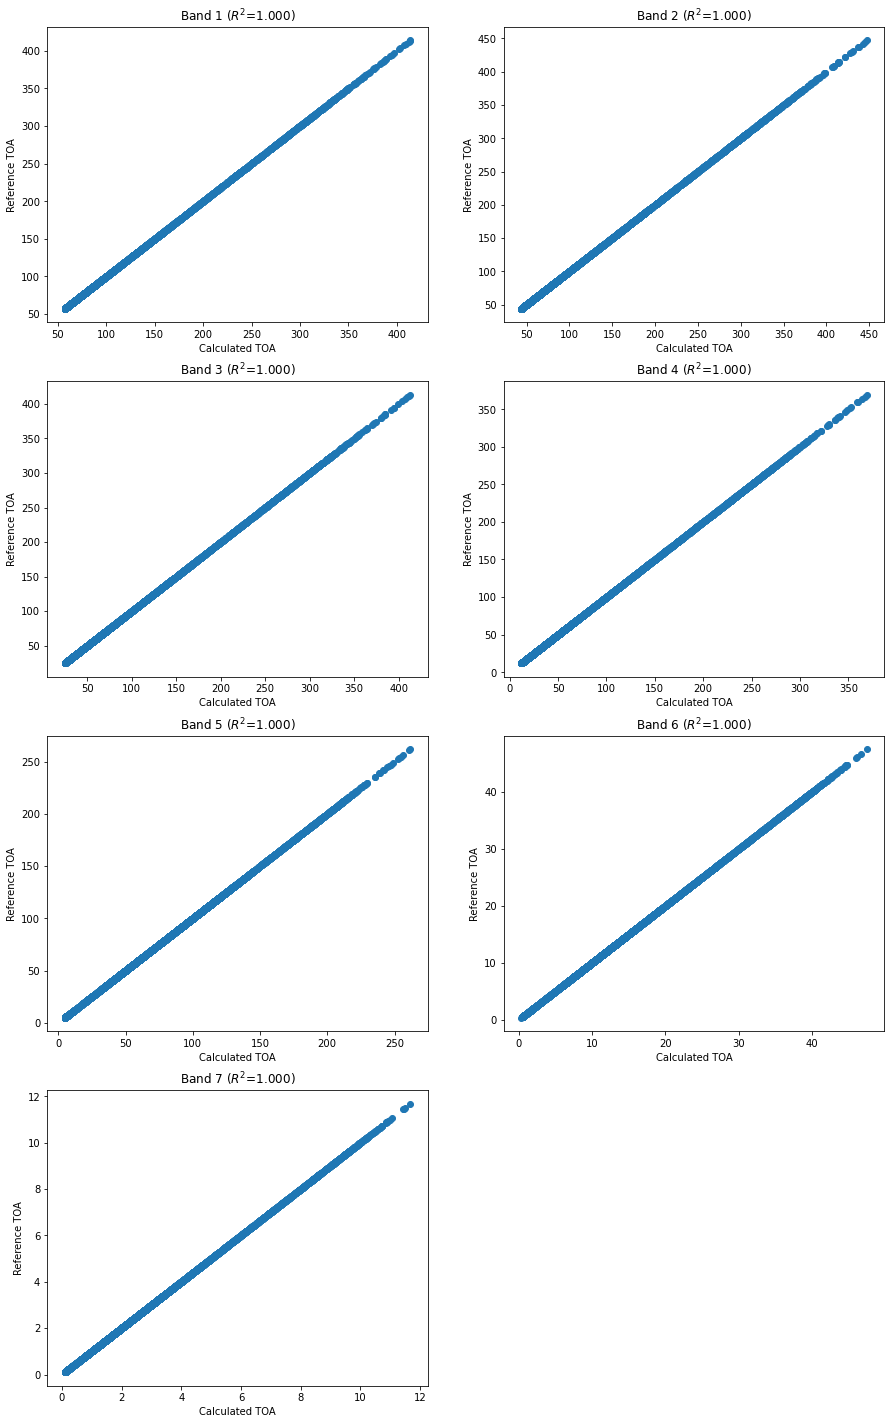

In [12]:
# Compare outputs
with rasterio.open(rad_tiff_path) as f:
  arr_rad = f.read()

show_r2_plots(arr_rad, arr_gainbias, figsize=(15, 25))

The histogram below shows one of the reasons why you want to radiometrically correct your images if your images are still in DN format. The histogram distribution of the bands are different. The most obvious one is band 5 which is the near-infrared band.

Text(0.5, 0, '$\\frac{watts}{sr}$ * $m^2$')

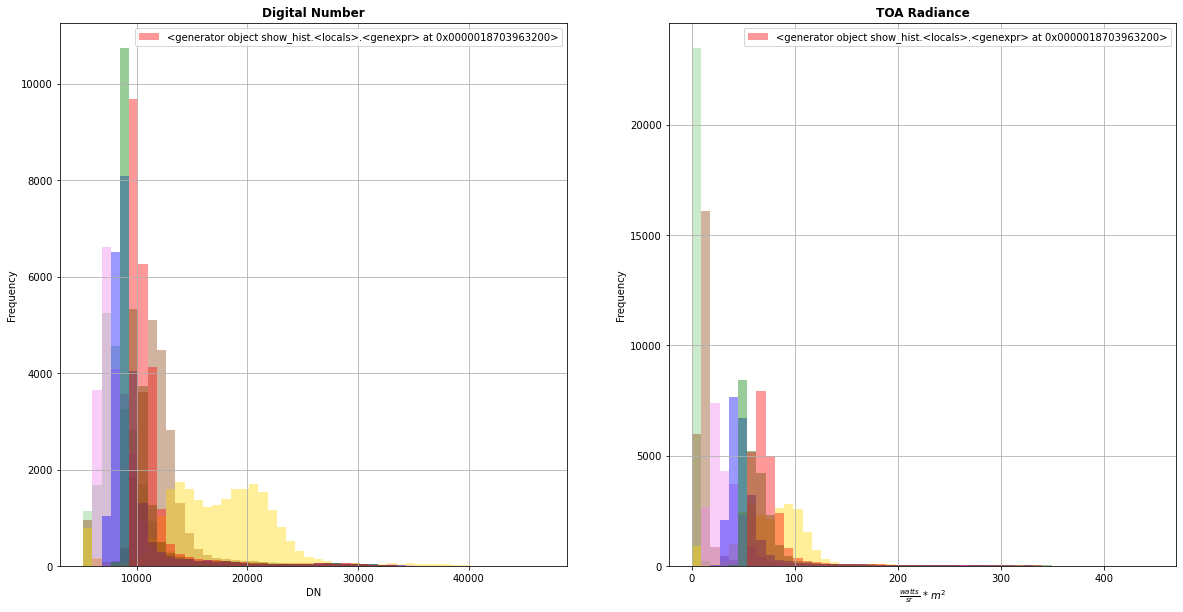

In [13]:
# Create scatter plot comparing reference and calculated data
fig, (ax_dn, ax_rad) = plt.subplots(1, 2, figsize=(20, 10))

show_hist(arr, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.4, ax=ax_dn, title="Digital Number")
show_hist(arr_gainbias, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.4, ax=ax_rad, title="TOA Radiance")

ax_dn.set_xlabel('DN')
ax_rad.set_xlabel('$\\frac{watts}{sr}$ * $m^2$')

## Radiance Scaling

$$
L_{\lambda{}} = \frac{LMAX-LMIN}{QMAX-QMIN} * (DN-QMIN) + LMIN
$$

In [14]:
# Create an empty array using the shape of the original array which will be used
# to save our results
arr_radscaling = np.zeros(arr.shape, np.float32)

for i, band_arr in enumerate(arr):

  # i starts at 0 index, but when referring to bands in the metadata
  # we start at 1. So we add an offset of 1.
  band_num = i + 1

  # Get L and Q values
  lmax = float(root.find(f".//RADIANCE_MAXIMUM_BAND_{band_num}").text)
  lmin = float(root.find(f".//RADIANCE_MINIMUM_BAND_{band_num}").text)
  qmin = float(root.find(f".//QUANTIZE_CAL_MIN_BAND_{band_num}").text)
  qmax = float(root.find(f".//QUANTIZE_CAL_MAX_BAND_{band_num}").text)
  print(f"BAND {band_num}")
  print(f"\tLmin/Lmax values:", lmin, lmax)
  print(f"\tQmin/Qmax values:", qmin, qmax)
  print()

  # Assign radiance scaled array to the new array via array indexing
  arr_radscaling[i] = ((lmax - lmin) / (qmax - qmin)) * (band_arr - qmin) + lmin

BAND 1
	Lmin/Lmax values: -63.78205 772.36383
	Qmin/Qmax values: 1.0 65535.0

BAND 2
	Lmin/Lmax values: -65.50922 793.27869
	Qmin/Qmax values: 1.0 65535.0

BAND 3
	Lmin/Lmax values: -60.19435 728.9187
	Qmin/Qmax values: 1.0 65535.0

BAND 4
	Lmin/Lmax values: -51.01944 617.81592
	Qmin/Qmax values: 1.0 65535.0

BAND 5
	Lmin/Lmax values: -31.30118 379.03918
	Qmin/Qmax values: 1.0 65535.0

BAND 6
	Lmin/Lmax values: -7.81956 94.69038
	Qmin/Qmax values: 1.0 65535.0

BAND 7
	Lmin/Lmax values: -2.64034 31.97296
	Qmin/Qmax values: 1.0 65535.0



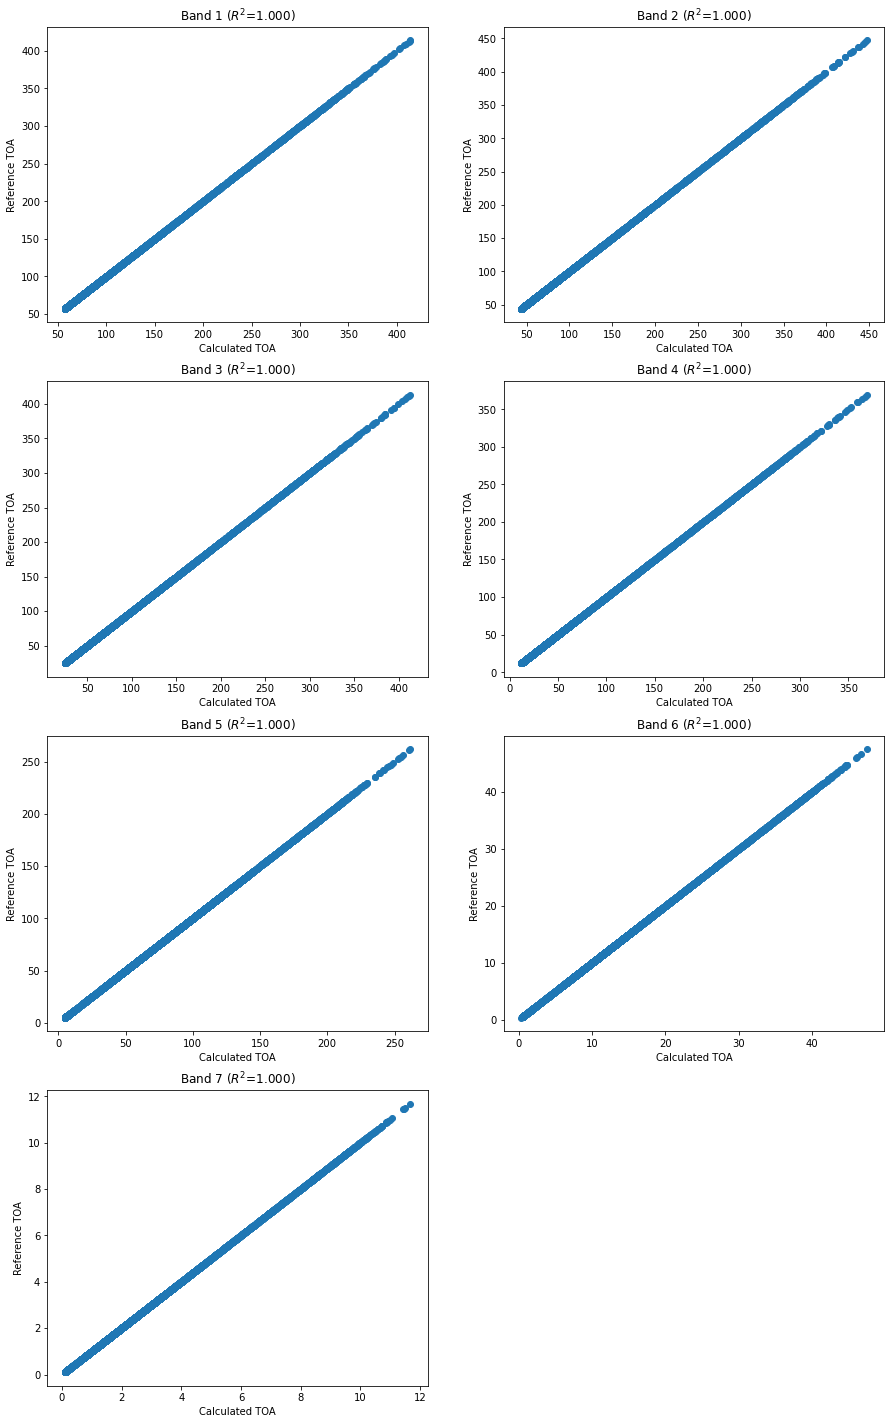

In [15]:
with rasterio.open(rad_tiff_path) as f:
  arr_rad = f.read()

show_r2_plots(arr_radscaling, arr_rad, figsize=(15, 25))

## Radiance Scaling vs Gain Bias Method

At least with Landsat 9, we can observe that radiance scaling and the gain/bias method lead to the same exact results.

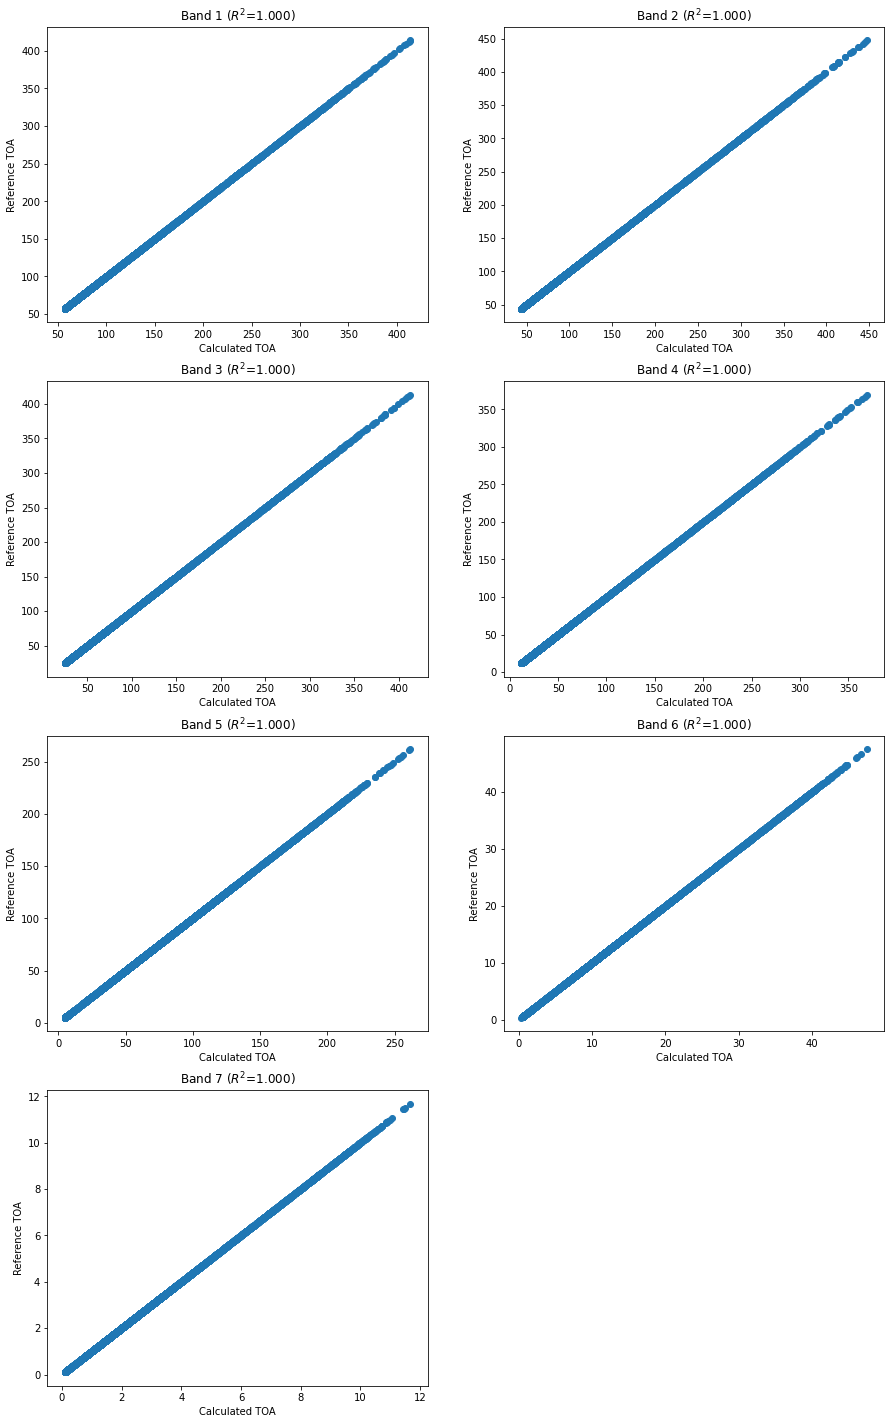

In [16]:
show_r2_plots(arr_gainbias, arr_radscaling, (15, 25))

## Radiance to Reflectance

For most sensors, you would need to first calculate radiance then use the radiance values to calculate reflectance. However, in the case of Landsat 8 and above you can go directly from DN to Reflectance. Landsat 8 and above do not provide ESUN values.

$$
\rho = \frac{\pi{}*L_{\lambda{}}*d^2}{ESUN*\cos({\theta{}_s})}
$$

We will not do this during this workshop.

## DN to Reflectance

Using TOA Reflectance with Landsat 8 and above you would want to use this formula to go from DN directly to TOA reflectance.

$$
\rho{}=\frac{M_p*DN+A_p}{sin({\theta{}}_s)}
$$

In [17]:
arr_dn_to_refl = np.zeros(arr.shape, np.float32)

for i, band_arr in enumerate(arr):
  band_num = i + 1
  mp = float(root.find(f".//REFLECTANCE_MULT_BAND_{band_num}").text)
  ap = float(root.find(f".//REFLECTANCE_ADD_BAND_{band_num}").text)
  sun_elev = float(root.find(f".//SUN_ELEVATION").text)
  arr_dn_to_refl[i] = (mp * band_arr + ap) / np.sin(np.radians(sun_elev))



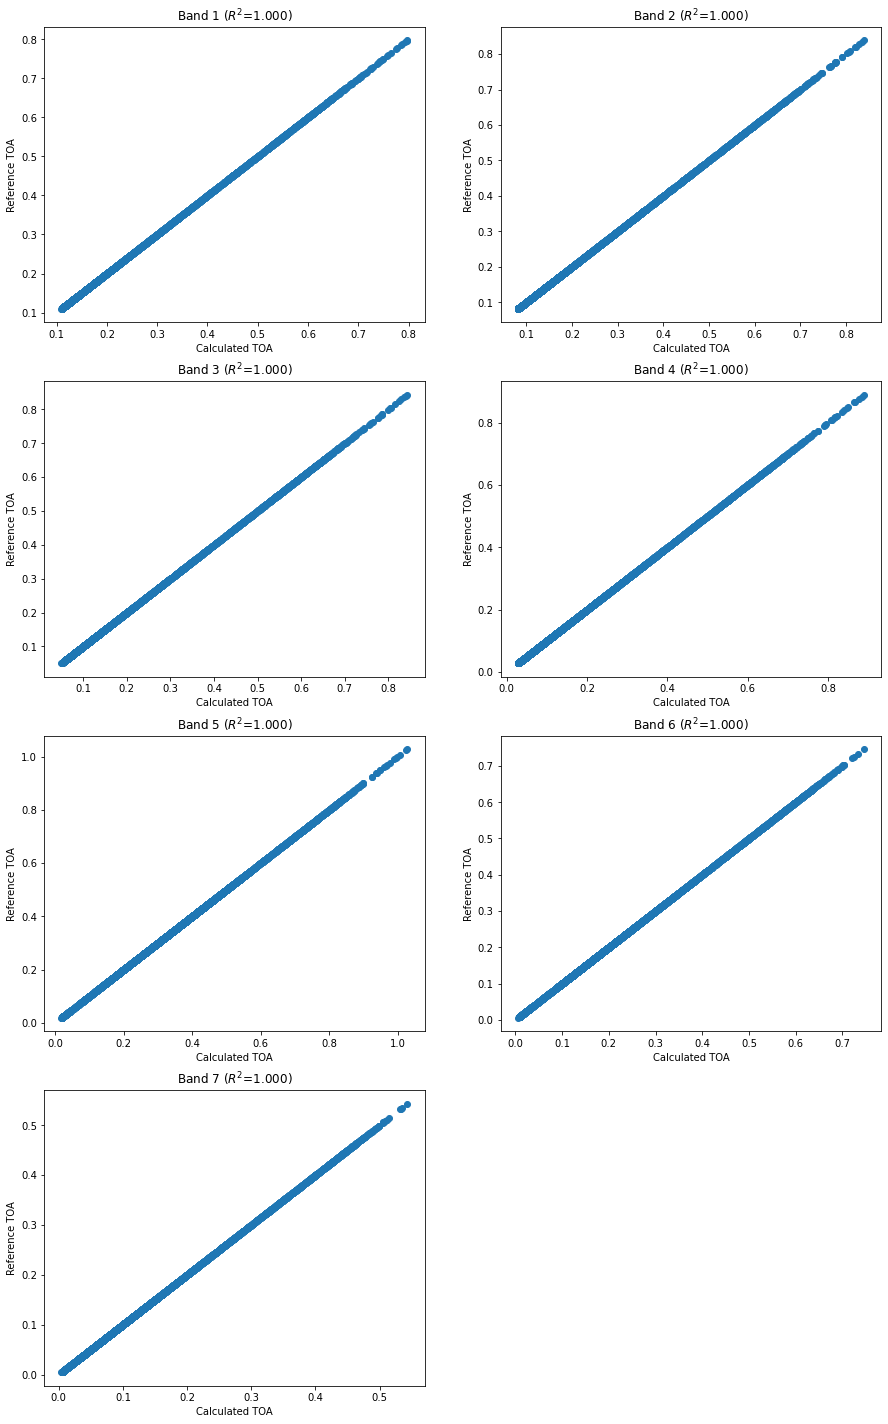

In [18]:
with rasterio.open(refl_tiff_path) as f:
  arr_refl = f.read()

show_r2_plots(arr_refl, arr_dn_to_refl, (15, 25))

In [19]:
# Save our results then download them to local storage
# Update the metadata dtype according to the array we are writing
# It is a float32 type now.
meta['dtype'] = arr_gainbias.dtype
with rasterio.open("L9_manual_radiance.tif", "w", **meta) as f:
  f.write(arr_gainbias)

with rasterio.open("L9_manual_reflectance.tif", "w", **meta) as f:
  f.write(arr_dn_to_refl)

# Image Preprocessing
For the image preprocessing section, we will be using a Landsat 9 image that is already in TOA Reflectance. The image is taken over Auckland, New Zealand.

Some notable issues we need to consider:

- Image has NaN (null) values
- Some reflectance values are greater than 1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Reflectance min/max values: 0.0014777636 1.9447049
Reflectance min/max values: nan nan


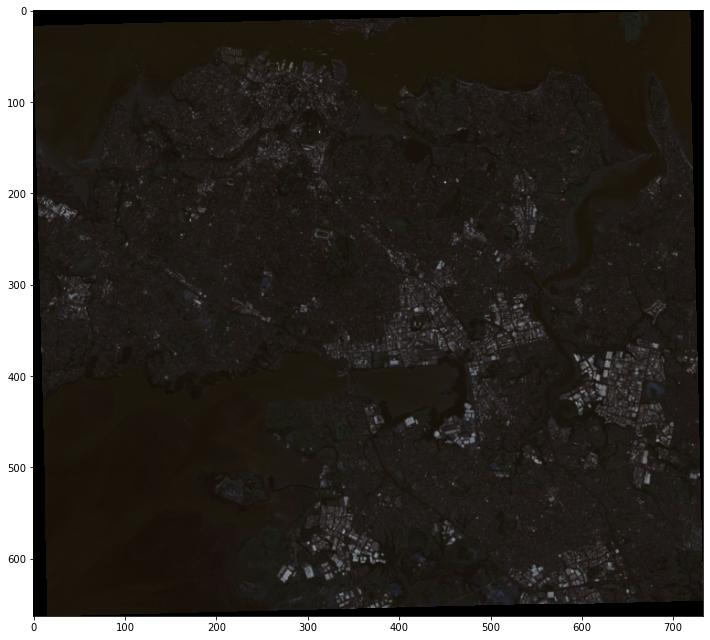

In [21]:
# Open data used for image processing section
with rasterio.open(img_proc_path) as f:
  meta = f.meta
  arr = f.read()

# Note that when we run the code below we get a warning that it will be clipped to the valid range
# which is 0 - 1. We are getting invalid reflection values.
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
show(arr[:3], ax=ax)

print("\nReflectance min/max values:", np.nanmin(arr), np.nanmax(arr))
# Note what happens when we try to calculate statistics with null values:
print("==========================")
print("Reflectance min/max values:", np.min(arr), np.max(arr))

## Clip to valid values

**When to use**: Image scaling, contrast adjustments

Valid reflectance values range from 0 - 1. So we should clip it to that range.

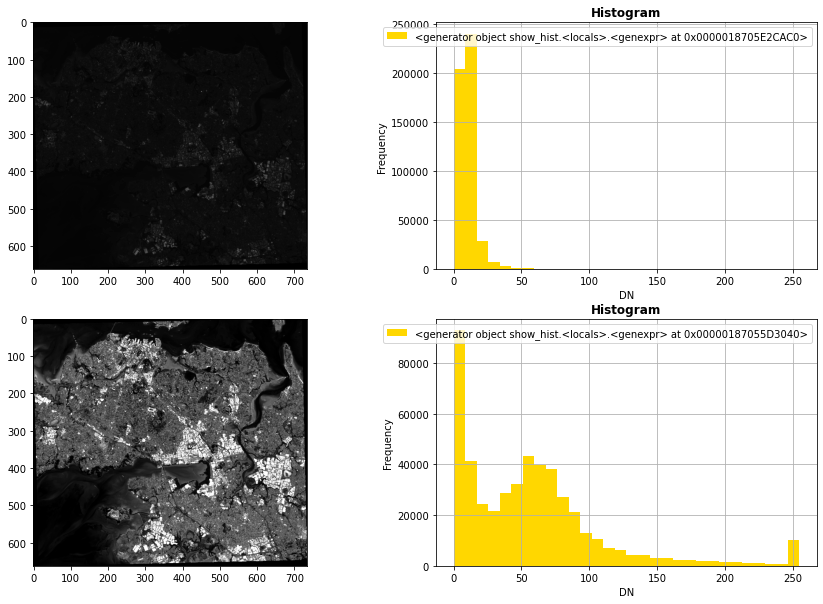

In [22]:
# Showing what happens when you scale when a few invalid outlier pixels distort the data
arr_8bit_unclipped = (arr[2] / np.nanmax(arr[2])) * 255
# Scale to 8bit
arr_8bit_unclipped = arr_8bit_unclipped.astype(np.uint8)

# Perform clipping using 98th precentile
low, high = np.nanpercentile(arr[2], (2, 98))
arr_8bit_clipped = rescale_intensity(arr[2], in_range=(low, high))
# Scale to 8bit
arr_8bit_clipped = (arr_8bit_clipped / np.nanmax(arr_8bit_clipped)) * 255
arr_8bit_clipped = arr_8bit_clipped.astype(np.uint8)

# Visualize
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
show(arr_8bit_unclipped, ax=ax[0][0], cmap="Greys_r")
show_hist(arr_8bit_unclipped, ax=ax[0][1], bins=30)
show(arr_8bit_clipped, ax=ax[1][0], cmap="Greys_r")
show_hist(arr_8bit_clipped, ax=ax[1][1], bins=30)

# Write to local storage for downloading
meta['count'] = 1
meta['dtype'] = np.uint8

with rasterio.open("landsat9-clipped.tif", "w", **meta) as f:
  f.write(np.expand_dims(arr_8bit_clipped, 0))

with rasterio.open("landsat9-unclipped.tif", "w", **meta) as f:
  f.write(np.expand_dims(arr_8bit_unclipped, 0))

## NDVI Image Generation
NDVI is a popular method to observe vegetation health.

NDVI min/max values: -0.9410257 0.85023016


<AxesSubplot:>

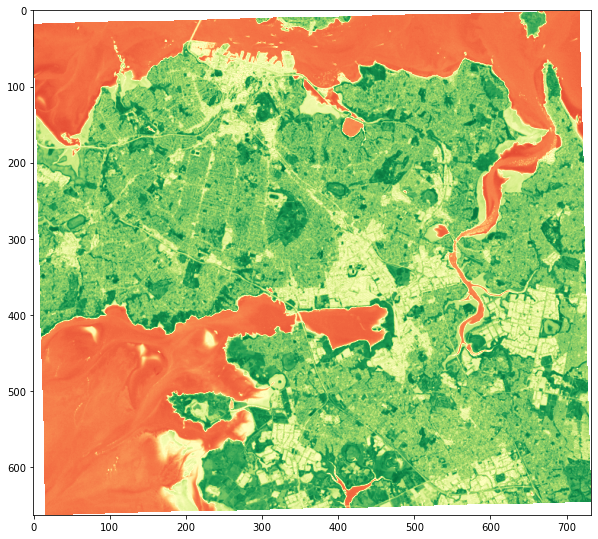

In [23]:
# NDVI
nir = arr[3]
red = arr[2]

ndvi = (nir - red) / (nir + red)
print("NDVI min/max values:", np.nanmin(ndvi), np.nanmax(ndvi))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
show(ndvi, cmap="RdYlGn", ax=ax)

## Contrast Adjustment
Contrast adjustment using CLAHE is an effective way of boosting the contrast.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original')

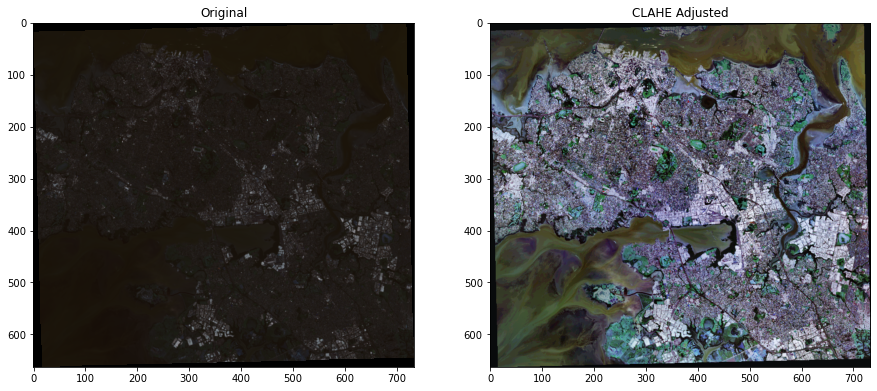

In [24]:
arr_clahe = np.zeros(arr.shape).astype(np.float32)

for i, band_arr in enumerate(arr):
  adjusted = equalize_adapthist(band_arr, kernel_size=None, clip_limit=0.05, nbins=256)
  arr_clahe[i] = adjusted

fig, (ax_orig, ax_clahe) = plt.subplots(1, 2, figsize=(15, 15))
show(arr_clahe[:3], ax=ax_clahe)
ax_clahe.set_title("CLAHE Adjusted")
show(arr[:3], ax=ax_orig)
ax_orig.set_title("Original")